In [7]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from sqlalchemy.engine import Engine
from sqlalchemy import create_engine

base_path = "/media/bruno/Arquivos/Desenvolvimento/DataScienceSalaries"
load_dotenv(f"{base_path}/config/.env")

True

In [2]:
def get_engine() -> Engine:
    user = os.getenv("DB_USER")
    pw = os.getenv("DB_PASS")
    db = os.getenv("DB_NAME")
    host = os.getenv("DB_HOST")
    port = os.getenv("DB_PORT")
    return create_engine(f"mysql+pymysql://{user}:{pw}@{host}:{port}/{db}")

## Abordagem job group
Nomes de cargos são diversos, porém muitas vezes as funções são parecidas. Este é uma situação comum, afinal cada empresa possui uma nomenclatura própria, de modo que tal fato também ocorreria no conjunto de dados avaliado. Por isso foi adotada uma abordagem de "job group", em que diversos nomes de cargos foram padronizados em uma função específica. Assim, avaliações do grupo se tornam mais relevantes e o caso de nomes diferentes para a mesma atividade é solucionado.

In [3]:
def group_job(df: pd.DataFrame) -> pd.DataFrame:
    job_group = {
        "Data Scientist": ["Data Scientist", "Data Science Consultant", "Principal Data Scientist", "Applied Data Scientist", "Applied Machine Learning Scientist", "Machine Learning Developer", "Data Specialist", "Staff Data Scientist"],

        "Data Engineer": ["Data Engineer", "Machine Learning Engineer", "Analytics Engineer", "Data Analytics Engineer", "Data Science Engineer", "Machine Learning Infrastructure Engineer", "Principal Data Engineer", "ETL Developer", "Cloud Data Engineer", "NLP Engineer", "Big Data Engineer", "Computer Vision Engineer", "ML Engineer", "Computer Vision Software Engineer"],

        "Data Analyst": ["Data Analyst", "BI Data Analyst", "Business Data Analyst", "Principal Data Analyst", "Financial Data Analyst", "Product Data Analyst", "Marketing Data Analyst", "Finance Data Analyst"],

        "Research Scientist": ["Research Scientist", "Machine Learning Scientist", "AI Scientist", "3D Computer Vision Researcher"],

        "Data Lead": ["Lead Data Engineer", "Head of Data Science", "Lead Data Scientist", "Lead Data Analyst", "Lead Machine Learning Engineer", "Head of Machine Learning", "Data Analytics Lead"],

        "Data Manager": ["Data Science Manager", "Director of Data Science", "Data Analytics Manager", "Head of Data", "Data Engineering Manager", "Director of Data Engineering",  "Machine Learning Manager"],

        "Data Architect": ["Data Architect", "Big Data Architect"]
    }

    convert = []
    for i in range(0, len(df)):
        value = df["job_title"].values[i]
        for group in job_group.keys():
            if value in job_group[group]:
                value = group
                break
        convert.append(value)
    df["job_title_pattern"] = convert
    return df

## Descrição dos dados

A função de engenharia é uma das mais infladas dentro do escopo de funções de dados. Este pode ser o resultado direto da necessidade de sustentabilidade, uma vez que o hype capitaneado por dados começa a esfriar. Trabalhos de engenharia se tornam mais valiosos em cenários de sustentação e longo prazo, na fundamentação de processos eficientes. Por outro lado, a arquitetura parece ser uma área bem pouco explorada, talvez pelo pouco conhecimento de arquitetura voltada para dados, comparando com o existente para arquitetura de software.

Sobre salários, importante comentar sobre a remuneração média do arquiteto. Como mencionado anteriormente, o arquiteto é um grupo pequeno, logo valores extremos são mais comuns nesse tipo de distribuição. Dito isso, a remuneração segue um padrão não muito diferente do senso comum, com cargos de gerência como os mais bem pagos e os analistas com menor salário.

De modo geral, o perfil pleno é mais abundante nas funções avaliadas, salvo nos pesquisadores. Existe uma grande queda quando se fala de sêniores e especialistas. Aqui, duas hipóteses são possíveis:
1. Área muito nova, de modo que ainda não se passou tempo suficiente para amadurecimento dos profissionais.
2. Existe uma barreira grande na passagem de pleno para sênior.

Estudos mais aprofundados e com outros dados devem ser procedidos para avaliar o caso da senioridade. Este repositório se conterá na visão descritiva de selários.

Por fim, é bem evidente a concentração das empresas no US. Tal fato leva a um certo monopólio do país em geração de tecnologias e projetos que envolvem dados, já que grande parte dos players estão alinhados no país.

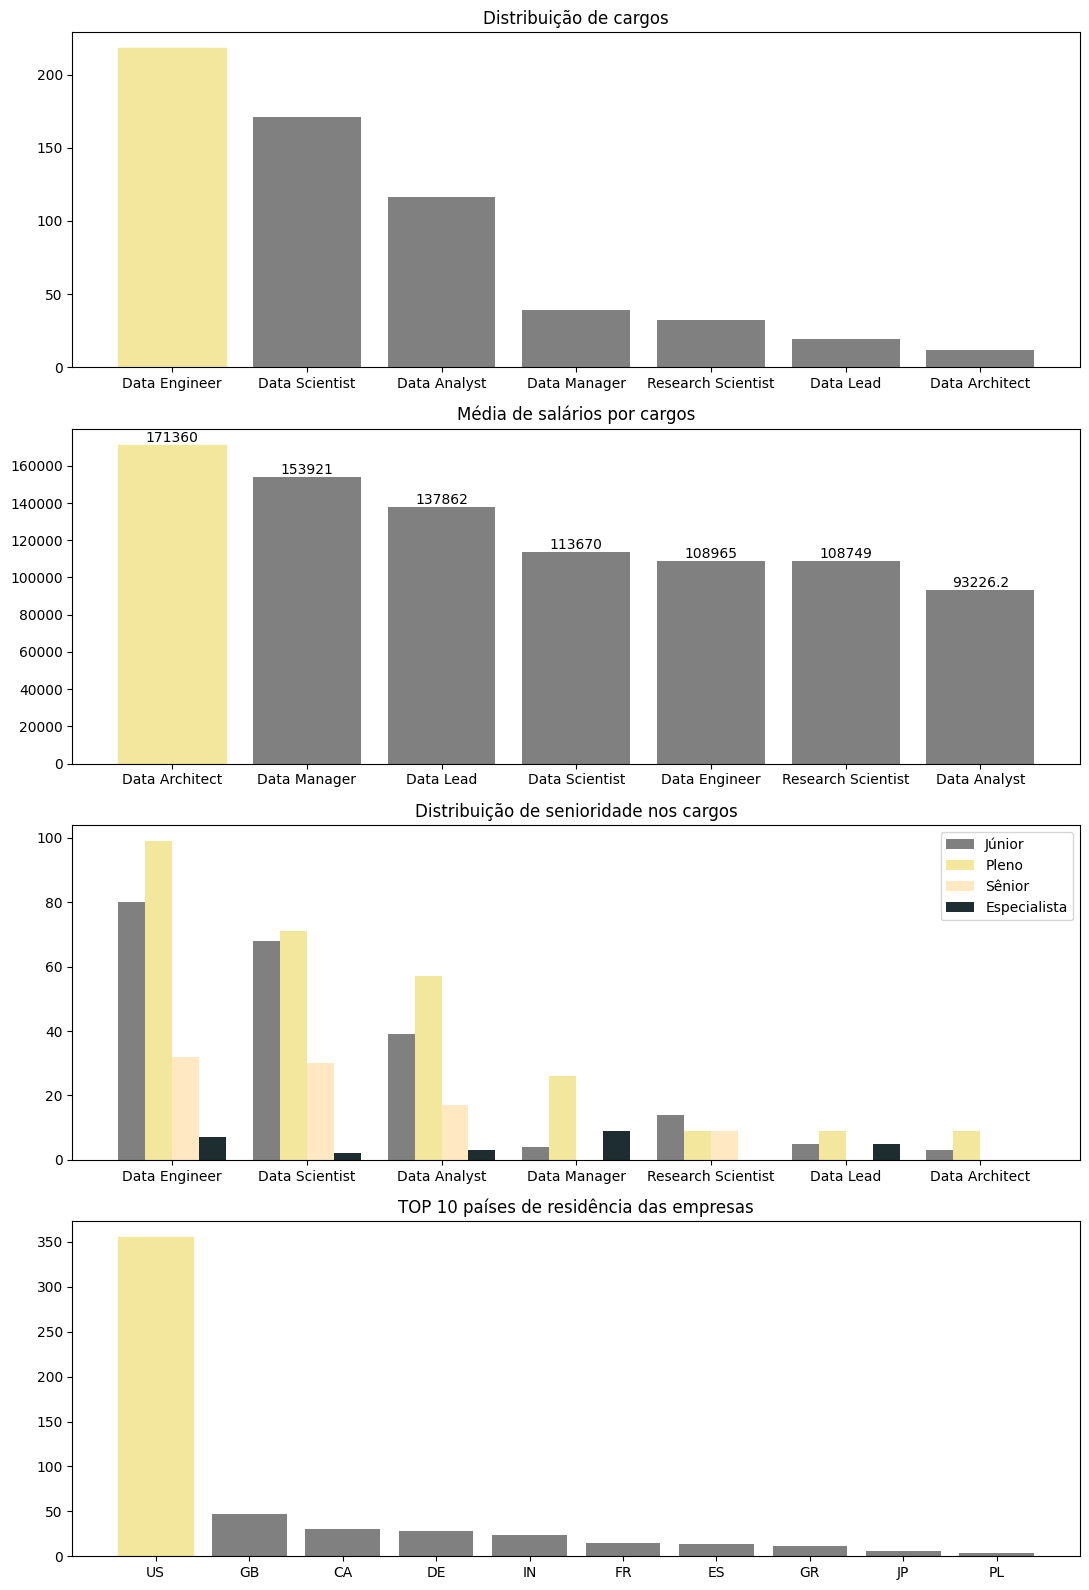

In [4]:
def description() -> None:
    engine = get_engine()
    with engine.connect() as con:
        dataset = pd.read_sql("select * from kaggle.ds_salaries", con)
        dataset = group_job(dataset)
        fig, ax = plt.subplots(4, 1, figsize=(11, 16))

        serie = dataset.groupby("job_title_pattern")["id"].count().sort_values(ascending=False)
        category_number = [i for i in range(0, len(serie))]
        category_job = serie.index
        chart = ax[0].bar(category_number, serie.values, color="#808080")
        ax[0].set_xticks(category_number, serie.index)
        ax[0].set_title("Distribuição de cargos")
        chart[0].set_color("#f3e79d")

        serie = dataset.groupby("job_title_pattern")["salary_usd"].mean().sort_values(ascending=False)
        category_number = [i for i in range(0, len(serie))]
        chart = ax[1].bar(category_number, serie.values, color="#808080")
        ax[1].set_xticks(category_number, serie.index)
        ax[1].bar_label(chart, label_type="edge")
        ax[1].set_title("Média de salários por cargos")
        chart[0].set_color("#f3e79d")

        serie = dataset.groupby(["job_title_pattern", "experience_level"])["id"].count()
        values = []
        x = np.array([i for i in range(0, len(category_job))])
        width = 0.2

        for experience in ["Júnior", "Pleno", "Sênior", "Especialista"]:
            iteration = []
            for job in category_job:
                if (job, experience) in serie.index:
                    iteration.append(serie[job, experience])
                else:
                    iteration.append(0)
            values.append(iteration)

        ax[2].bar(x - 1.5 * width, values[0], width, label="Júnior", color="#808080")
        ax[2].bar(x - 0.5 * width, values[1], width, label="Pleno", color="#f3e79d")
        ax[2].bar(x + 0.5 * width, values[2], width, label="Sênior", color="#FFE8C2")
        ax[2].bar(x + 1.5 * width, values[3], width, label="Especialista", color="#1E2D2F")
        ax[2].set_title("Distribuição de senioridade nos cargos")
        ax[2].set_xticks(x, category_job)
        ax[2].legend()

        serie = dataset.groupby("company_location")["id"].count().sort_values(ascending=False)[:10]
        category_number = [i for i in range(0, len(serie))]
        chart = ax[3].bar(category_number, serie.values, color="#808080")
        ax[3].set_xticks(category_number, serie.index)
        ax[3].set_title("TOP 10 países de residência das empresas")
        chart[0].set_color("#f3e79d")

        fig.tight_layout()
        plt.show()


description()

Para cada função, os salários não apresentam grande quantidades de extremos, salvo o cientista de dados com 4 outliers. Uma avaliação espacial revela um menor range de valores não anômalos para o caso do Analista, além de uma maior homogeneidade aparente nos cargos de Gerente e Analista.

O modo de trabalho remoto oferece maior remuneração média nos casos de Pesquisadores e Gerentes, porém é interessante avaliar que o modelo híbrido ofecere menor remuneração em todos os casos. Por outro lado, o modo de trabalho remoto remunera melhor os Cientistas, Analistas, Engenheiros e Leads. Uma hipótese possível seria o menor gasto com infraestrutura física que as empresas teriam, que podem ser convertidos em melhores ofertas salaridas.

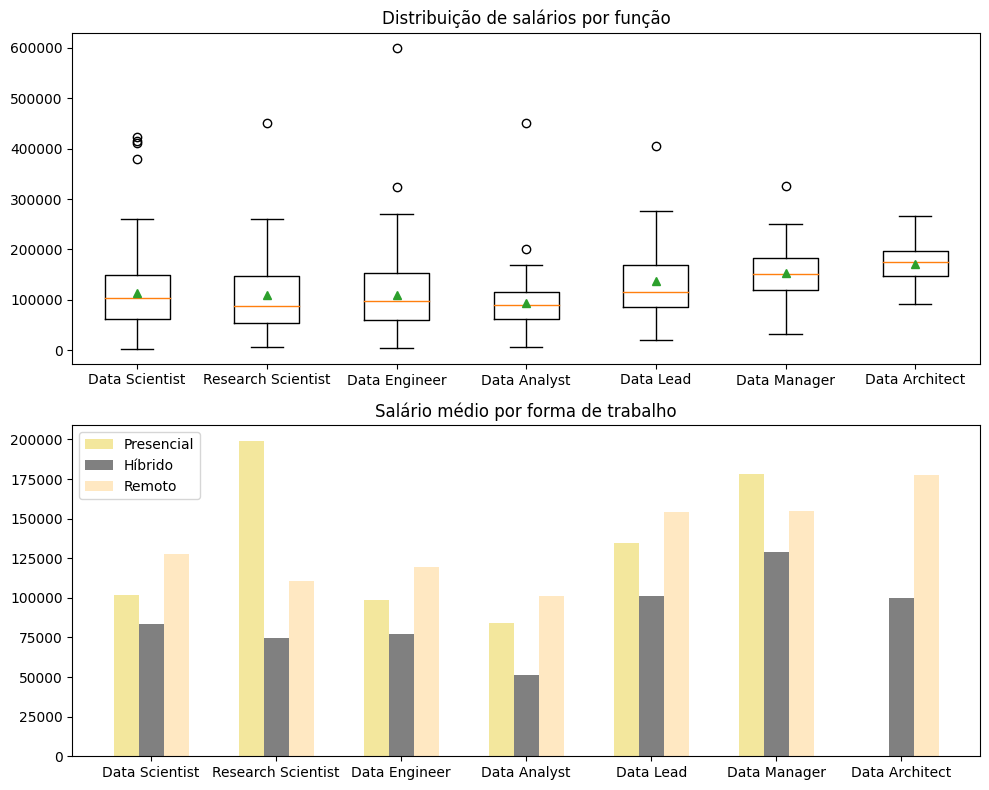

In [6]:
def salaries() -> None:
    engine = get_engine()
    with engine.connect() as con:
        dataset = pd.read_sql("select * from kaggle.ds_salaries", con)
        dataset = group_job(dataset)
        fig, ax = plt.subplots(2, 1, figsize=(10, 8))

        bpvalues = []
        jobs = dataset["job_title_pattern"].unique()

        for job in jobs:
            subset = dataset.query(f"job_title_pattern == '{job}'")
            bpvalues.append(subset["salary_usd"].values)

        ax[0].boxplot(bpvalues, showmeans=True, labels=jobs)
        ax[0].set_title("Distribuição de salários por função")

        barvalues = []
        ratios = [0, 50, 100]
        for code in ratios:
            iteration = []
            for job in jobs:
                subset = dataset.loc[(dataset["job_title_pattern"] == job) & (dataset["remote_ratio"] == code)]
                if len(subset) == 0:
                    iteration.append(0)
                else:
                    iteration.append(np.mean(subset["salary_usd"].values))
            barvalues.append(iteration)

        width = 0.2
        x = np.array([i for i in range(0, len(jobs))])
        ax[1].bar(x - 1 * width, barvalues[0], width, label="Presencial", color="#f3e79d")
        ax[1].bar(x, barvalues[1], width, label="Híbrido", color="#808080")
        ax[1].bar(x + 1 * width, barvalues[2], width, label="Remoto", color="#FFE8C2")
        ax[1].set_title("Salário médio por forma de trabalho")
        ax[1].set_xticks(x, jobs)
        ax[1].legend()

        plt.tight_layout()
        plt.show()


salaries()

Resumindo as principais features, podemos verificar que os dados de remuneração são bem assimétricos (skewness), com valores frequentemente mais baixos que a média. Ou seja, a presença de remunerações extremamante elevadas (observada no boxplot anterior) causa um forte impacto na média, que não reflete bem a maior parte da distribuição. O alto índice de kurtosis revela uma curva bem comprimida, em que valores mais baixos são bem mais provável que valores mais altos. A diferença entre o maior salário e a mediana é aproximadamente 500k, enquanto a diferença entre o menor salário e a mediana é de aproximadamente 100k.

Avaliando as categóricas, fica evidente as conclusões do primeiro bloco, em que Engenheiros formam a maior quantidade de funcionários e que a maioria das empresas estão no US. Adicionamente, verificamos que o trabalho removo é bem mais frequente e a modalidade full-time também, o que indica uma boa tendência das empresas adotarem esta modalidade de contratação. Senioridade intermediaria (nível pleno) é mais frequente, como também verificado graficamente por função.

In [32]:
def resume() -> None:
    engine = get_engine()
    with engine.connect() as con:
        dataset = pd.read_sql("select * from kaggle.ds_salaries", con)
        dataset = group_job(dataset)

        metrics = []
        features = [
            {"column": "job_title_pattern", "categorical": True},
            {"column": "experience_level", "categorical": True},
            {"column": "employment_type", "categorical": True},
            {"column": "salary_usd", "categorical": False},
            {"column": "employee_residence", "categorical": True},
            {"column": "remote_ratio", "categorical": True},
            {"column": "company_location", "categorical": True},
            {"column": "company_size", "categorical": True}
        ]

        for feature in features:
            column, is_categorical = feature["column"], feature["categorical"]
            metrics.append({
                "feature": column,
                "distinct": len(dataset[column].unique()) if is_categorical else None,
                "frequent": dataset[column].mode()[0] if is_categorical else "-",
                "min": round(np.min(dataset[column].values)) if not is_categorical else None,
                "median": round(np.median(dataset[column].values)) if not is_categorical else None,
                "mean": round(np.mean(dataset[column].values)) if not is_categorical else None,
                "max": round(np.max(dataset[column].values)) if not is_categorical else None,
                "range": round(np.max(dataset[column]) - np.min(dataset[column])) if not is_categorical else None,
                "skew": round(stats.skew(dataset[column].values), 2) if not is_categorical else None,
                "kurtosis": round(stats.kurtosis(dataset[column].values), 2) if not is_categorical else None
            })

        metrics = pd.DataFrame(metrics)
        return metrics


resume()

,feature,distinct,frequent,min,median,mean,max,range,skew,kurtosis
0,job_title_pattern,7.0,Data Engineer,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,experience_level,4.0,Pleno,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,employment_type,4.0,Full-time,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,salary_usd,NaN,-,2859.0,101570.0,112298.0,600000.0,597141.0,1.66,6.29
4,employee_residence,57.0,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,remote_ratio,3.0,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,company_location,50.0,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,company_size,3.0,Média,NaN,NaN,NaN,NaN,NaN,NaN,NaN
